# Import packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import shutil
import os


import re
import math

from tensorflow import keras
from tqdm import tqdm

import cartopy
import cartopy.feature as cfeature

import cartopy.crs as ccrs
import matplotlib.pylab as plb
import matplotlib.image as imag

from matplotlib.ticker import FuncFormatter

from moviepy.editor import *

from preprocessing_functions import *

2024-04-24 00:28:57.398646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 00:29:23.124461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
config_dir = 'ablated'

def set_plot_params():
    '''
    This function sets the plot parameters for matplotlib.
    '''
    plt.close('all')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rc('font', family='sans')
    plt.rcParams.update({'font.size': 10,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 10,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2,
                        "pgf.texsystem": "pdflatex"
                        })
set_plot_params()

In [3]:
data_path = "/ocean/projects/atm200007p/jlin96/longSPrun_clean/"
sp_data = load_data(month = 9, year = 1, data_path = data_path)

In [19]:
num_timesteps = 336
num_models = len(os.listdir("../coupling_folder/h5_models")) - 1

sp_data_test_input = np.load('testing_data/test_input.npy')
sp_data_test_target = np.load('testing_data/test_target.npy')

sp_data_test_target = np.concatenate((sp_data_test_target[:,:30,:,:], \
                                      np.zeros((sp_data_test_target.shape[0], 5, sp_data_test_target.shape[2], sp_data_test_target.shape[3])), \
                                      sp_data_test_target[:,30:,:,:]), axis = 1)

inp_sub = np.loadtxt('../coupling_folder/norm_files/inp_sub.txt')[None,:]
inp_div = np.loadtxt('../coupling_folder/norm_files/inp_div.txt')[None,:]
out_scale = np.loadtxt('../coupling_folder/norm_files/out_scale.txt')[None,:]

reshaped_input = (reshape_input(sp_data_test_input).transpose() - inp_sub)/inp_div

dp = sp_data['gw'] * (sp_data["P0"] * sp_data["hyai"] + sp_data['hybi']*sp_data['NNPSBSP']).diff(dim = "ilev")
error_weights = dp[:336,:,:,:].values
error_weights_norm = np.swapaxes((error_weights/np.sum(error_weights)), 1, 2)

heating_true = sp_data_test_target[:,:30,:,:]
moistening_true = sp_data_test_target[:,30:,:,:]

print(heating_true.shape)
print(moistening_true.shape)

(175, 2752512)
(336, 30, 64, 128)
(336, 30, 64, 128)


In [20]:
def reverse_reshape(reshaped_arr, original_shape):
    '''
    reshaped_arr should be num_samples x features for this function to work properly
    '''
    arr = reshaped_arr.transpose().reshape(60, original_shape[0], original_shape[2], original_shape[3], order='F')
    ans = arr.transpose(1,0,2,3)
    print(ans.shape)
    return ans

In [21]:
model_folder = '../coupling_folder/h5_models/'
example_model_path = model_folder + 'ablated_model_001.h5'

In [22]:
def get_diffs(nn_model_path):
    nn_model = keras.models.load_model(nn_model_path, compile = False)
    nn_predict = nn_model.predict(reshaped_input)/out_scale
    nn_predict = np.concatenate((nn_predict[:,0:30], np.zeros((nn_predict.shape[0], 5)), nn_predict[:,30:]), axis = 1)
    nn_predict_unshaped = reverse_reshape(nn_predict, sp_data_test_target.shape)
    heating_predict = nn_predict_unshaped[:,0:30,:,:]
    moistening_predict = nn_predict_unshaped[:,30:60,:,:]
    diff_predict_unshaped = nn_predict_unshaped - sp_data_test_target
    heating_diff = diff_predict_unshaped[:,0:30,:,:]
    moistening_diff = diff_predict_unshaped[:,30:60,:,:]
    return heating_predict, moistening_predict, heating_diff, moistening_diff

In [23]:
nn_model_path = '../coupling_folder/h5_models/ablated_model_001.h5'
heating_predict, moistening_predict, heating_diff, moistening_diff = get_diffs(nn_model_path)

86016/86016 [==============================] - 154s 2ms/step
(336, 60, 64, 128)


In [24]:
heating_rmse = np.average(heating_diff**2, weights = error_weights_norm)**.5
moistening_rmse = np.average(moistening_diff**2, weights = error_weights_norm)**.5

print('heating rmse: ')
print(heating_rmse)

print('moistening rmse: ')
print(moistening_rmse)

  im1 = axs[0, 0].pcolormesh(X, Y, np.mean(heating_true, axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)

  im2 = axs[0, 1].pcolormesh(X, Y, np.mean(moistening_true, axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)

  im3 = axs[1, 0].pcolormesh(X, Y, np.mean(heating_predict, axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)

  im4 = axs[1, 1].pcolormesh(X, Y, np.mean(moistening_predict, axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)

  im5 = axs[2, 0].pcolormesh(X, Y, np.mean(heating_diff**2, axis = (0,3))**.5, cmap='Reds', vmin = 0, vmax = 8e-5)

  im6 = axs[2, 1].pcolormesh(X, Y, np.mean(moistening_diff**2, axis = (0,3))**.5, cmap='Blues', vmin = 0, vmax = 6e-8)



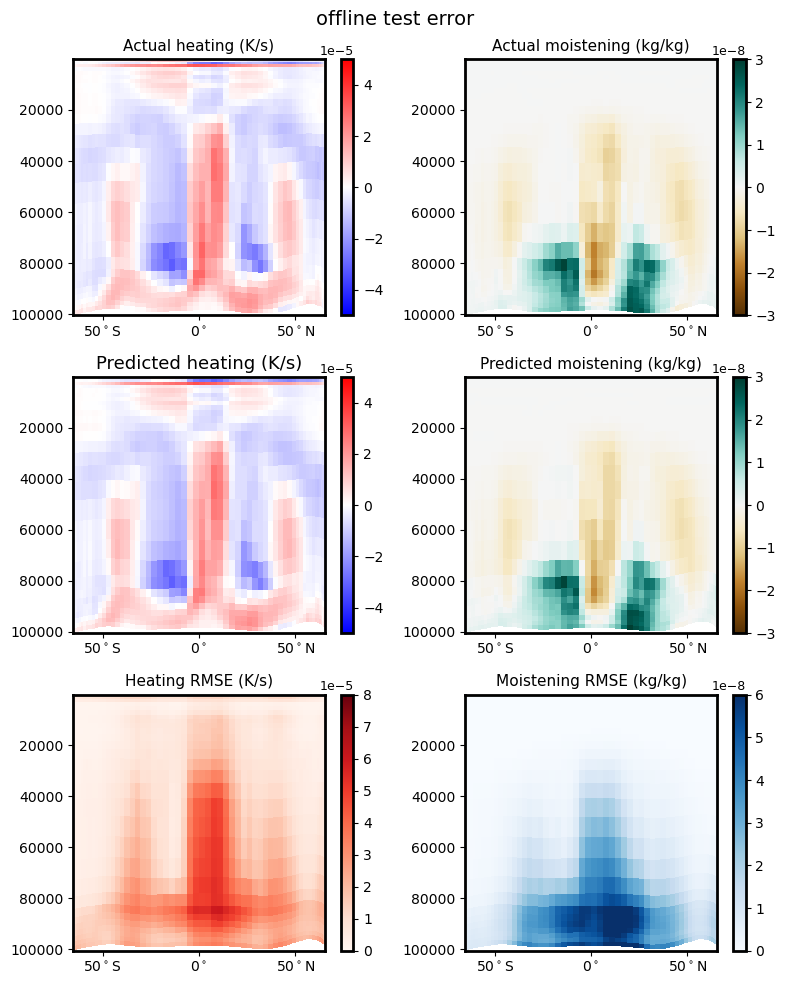

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(8, 10))

X, Y = np.meshgrid(np.sin(sp_data["lat"]*np.pi/180), np.array(range(30)))
pressure_grid_plot_p1 = (sp_data['P0'].values[:, np.newaxis] * sp_data['hyam'].values)[:,:,np.newaxis, np.newaxis]
pressure_grid_plot_p2 = sp_data['hybm'].values[:,:,np.newaxis,np.newaxis]*sp_data['NNPSBSP'].values[:,np.newaxis,:,:]
pressure_grid_plot = pressure_grid_plot_p1 + pressure_grid_plot_p2
Y = np.mean(pressure_grid_plot, axis = (0,3))

# Plot 1: actual heating
im1 = axs[0, 0].pcolormesh(X, Y, np.mean(heating_true, axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)
axs[0, 0].invert_yaxis()
axs[0, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[0, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar1 = fig.colorbar(im1, ax=axs[0, 0])
cbar1.ax.yaxis.get_offset_text().set_size(9)
axs[0, 0].set_title("Actual heating (K/s)", fontsize = 11)

# Plot 2: actual moistening
im2 = axs[0, 1].pcolormesh(X, Y, np.mean(moistening_true, axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)
axs[0, 1].invert_yaxis()
axs[0, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[0, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar2 = fig.colorbar(im2, ax=axs[0, 1])
cbar2.ax.yaxis.get_offset_text().set_size(9)
axs[0, 1].set_title("Actual moistening (kg/kg)", fontsize = 11)

# Plot 3: heating zonal mean squared error
im3 = axs[1, 0].pcolormesh(X, Y, np.mean(heating_predict, axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)
axs[1, 0].invert_yaxis()
axs[1, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[1, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar3 = fig.colorbar(im3, ax=axs[1, 0])
cbar3.ax.yaxis.get_offset_text().set_size(9)
axs[1, 0].set_title("Predicted heating (K/s)", fontsize = 13)

# Plot 4: moistening zonal mean squared error
im4 = axs[1, 1].pcolormesh(X, Y, np.mean(moistening_predict, axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)
axs[1, 1].invert_yaxis()
axs[1, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[1, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar4 = fig.colorbar(im4, ax=axs[1, 1])
cbar4.ax.yaxis.get_offset_text().set_size(9)
axs[1, 1].set_title("Predicted moistening (kg/kg)", fontsize = 11)

# Plot 5: heating zonal mean squared error
im5 = axs[2, 0].pcolormesh(X, Y, np.mean(heating_diff**2, axis = (0,3))**.5, cmap='Reds', vmin = 0, vmax = 8e-5)
axs[2, 0].invert_yaxis()
axs[2, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[2, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar5 = fig.colorbar(im5, ax=axs[2, 0])
cbar5.ax.yaxis.get_offset_text().set_size(9)
axs[2, 0].set_title("Heating RMSE (K/s)", fontsize = 11)

# Plot 6: moistening zonal mean squared error
im6 = axs[2, 1].pcolormesh(X, Y, np.mean(moistening_diff**2, axis = (0,3))**.5, cmap='Blues', vmin = 0, vmax = 6e-8)
axs[2, 1].invert_yaxis()
axs[2, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
axs[2, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
cbar6 = fig.colorbar(im6, ax=axs[2, 1])
cbar6.ax.yaxis.get_offset_text().set_size(9)
axs[2, 1].set_title("Moistening RMSE (kg/kg)", fontsize = 11)

plt.suptitle("offline test error", fontsize = 14)

plt.tight_layout()
plt.show()

In [28]:
config_dir = 'ablated'
num_timesteps = 336
fps = 10
model_rank = 1

model_name = config_dir + "_model_" + str(model_rank).zfill(3)
diagnostic_path = 'diagnostic_error/' + config_dir + "_model_" + str(model_rank).zfill(3)
diagnostic_path_latlev = diagnostic_path + '/latlev/'
diagnostic_path_worldmap = diagnostic_path + '/worldmap/'
if os.path.exists(diagnostic_path):
    shutil.rmtree(diagnostic_path)
os.makedirs(diagnostic_path, exist_ok=True)
os.makedirs(diagnostic_path_latlev, exist_ok = True)
os.makedirs(diagnostic_path_worldmap, exist_ok = True)
latlev_image_files = []
worldmap_image_files = []

In [29]:
!hostname

r339.ib.bridges2.psc.edu


In [30]:
# Increase font sizes
deltat = 2
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

for t in range(num_timesteps//deltat):
    fig, axs = plt.subplots(3, 2, figsize=(8, 10))

    X, Y = np.meshgrid(np.sin(sp_data["lat"]*np.pi/180), np.array(range(30)))
    pressure_grid_plot_p1 = (sp_data['P0'].values[:, np.newaxis] * sp_data['hyam'].values)[:,:,np.newaxis, np.newaxis]
    pressure_grid_plot_p2 = sp_data['hybm'].values[:,:,np.newaxis,np.newaxis]*sp_data['NNPSBSP'].values[:,np.newaxis,:,:]
    pressure_grid_plot = pressure_grid_plot_p1 + pressure_grid_plot_p2
    Y = np.mean(pressure_grid_plot[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3))

    # Plot 1: actual heating
    im1 = axs[0, 0].pcolormesh(X, Y, np.mean(heating_true[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)
    axs[0, 0].invert_yaxis()
    axs[0, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[0, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar1 = fig.colorbar(im1, ax=axs[0, 0])
    cbar1.ax.yaxis.get_offset_text().set_size(9)
    axs[0, 0].set_title("Actual heating (K/s)", fontsize = 11)

    # Plot 2: actual moistening
    im2 = axs[0, 1].pcolormesh(X, Y, np.mean(moistening_true[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)
    axs[0, 1].invert_yaxis()
    axs[0, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[0, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar2 = fig.colorbar(im2, ax=axs[0, 1])
    cbar2.ax.yaxis.get_offset_text().set_size(9)
    axs[0, 1].set_title("Actual moistening (kg/kg)", fontsize = 11)

    # Plot 3: heating zonal mean squared error
    im3 = axs[1, 0].pcolormesh(X, Y, np.mean(heating_predict[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)
    axs[1, 0].invert_yaxis()
    axs[1, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[1, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar3 = fig.colorbar(im3, ax=axs[1, 0])
    cbar3.ax.yaxis.get_offset_text().set_size(9)
    axs[1, 0].set_title("Predicted heating (K/s)", fontsize = 13)

    # Plot 4: moistening zonal mean squared error
    im4 = axs[1, 1].pcolormesh(X, Y, np.mean(moistening_predict[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)
    axs[1, 1].invert_yaxis()
    axs[1, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[1, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar4 = fig.colorbar(im4, ax=axs[1, 1])
    cbar4.ax.yaxis.get_offset_text().set_size(9)
    axs[1, 1].set_title("Predicted moistening (kg/kg)", fontsize = 11)

    # Plot 5: heating zonal mean squared error
    im5 = axs[2, 0].pcolormesh(X, Y, np.mean(heating_diff[t*deltat:t*deltat+deltat,:,:,:]**2, axis = (0,3))**.5, cmap='Reds', vmin = 0, vmax = 8e-5)
    axs[2, 0].invert_yaxis()
    axs[2, 0].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[2, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar5 = fig.colorbar(im5, ax=axs[2, 0])
    cbar5.ax.yaxis.get_offset_text().set_size(9)
    axs[2, 0].set_title("Heating RMSE (K/s)", fontsize = 11)

    # Plot 6: moistening zonal mean squared error
    im6 = axs[2, 1].pcolormesh(X, Y, np.mean(moistening_diff[t*deltat:t*deltat+deltat,:,:,:]**2, axis = (0,3))**.5, cmap='Blues', vmin = 0, vmax = 6e-8)
    axs[2, 1].invert_yaxis()
    axs[2, 1].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    axs[2, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    cbar6 = fig.colorbar(im6, ax=axs[2, 1])
    cbar6.ax.yaxis.get_offset_text().set_size(9)
    axs[2, 1].set_title("Moistening RMSE (kg/kg)", fontsize = 11)

    plt.suptitle("[diagnostic] Day " + str(t//24) + ", Hour " + str(t%24), fontsize = 14)

    plt.tight_layout()
    latlev_image_file = 'diagnostic_error/' + model_name + '/latlev/' + 'timestep_' + str(t).zfill(4) + '.png'
    plt.savefig(latlev_image_file)
    latlev_image_files.append(latlev_image_file)
    plt.clf()
    plt.close('all')

latlev_clip = ImageSequenceClip(sorted(latlev_image_files), fps = fps)
latlev_clip.write_videofile(diagnostic_path_latlev + 'latlev.mp4')

  im1 = axs[0, 0].pcolormesh(X, Y, np.mean(heating_true[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)

  im2 = axs[0, 1].pcolormesh(X, Y, np.mean(moistening_true[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)

  im3 = axs[1, 0].pcolormesh(X, Y, np.mean(heating_predict[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='bwr', vmin = -5e-5, vmax = 5e-5)

  im4 = axs[1, 1].pcolormesh(X, Y, np.mean(moistening_predict[t*deltat:t*deltat+deltat,:,:,:], axis = (0,3)), cmap='BrBG', vmin = -3e-8, vmax = 3e-8)

  im5 = axs[2, 0].pcolormesh(X, Y, np.mean(heating_diff[t*deltat:t*deltat+deltat,:,:,:]**2, axis = (0,3))**.5, cmap='Reds', vmin = 0, vmax = 8e-5)

  im6 = axs[2, 1].pcolormesh(X, Y, np.mean(moistening_diff[t*deltat:t*deltat+deltat,:,:,:]**2, axis = (0,3))**.5, cmap='Blues', vmin = 0, vmax = 6e-8)



Moviepy - Building video diagnostic_error/ablated_model_001/latlev/latlev.mp4.
Moviepy - Writing video diagnostic_error/ablated_model_001/latlev/latlev.mp4



Moviepy - Done !
Moviepy - video ready diagnostic_error/ablated_model_001/latlev/latlev.mp4


In [31]:
pressure_grid_p1 = (sp_data['P0'].values[:, np.newaxis] * sp_data['hyai'].values)[:,:,np.newaxis, np.newaxis]
pressure_grid_p2 = sp_data['hybi'].values[:,:,np.newaxis,np.newaxis]*sp_data['NNPSBSP'].values[:,np.newaxis,:,:]
pressure_grid = pressure_grid_p1 + pressure_grid_p2
dp = pressure_grid[:,1:31,:,:] - pressure_grid[:,0:30,:,:]

deltat = 2
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 6.5
plt.rcParams['ytick.labelsize'] = 6.5

for t in range(num_timesteps//deltat):
    fig, ax = plt.subplots(2,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                    figsize=(13,4.2))
    fig.subplots_adjust(right=0.85)
    fig.subplots_adjust(wspace=0.32)
    # fig.subplots_adjust(hspace=0) 

    pressure_weighting = dp[t*deltat:t*deltat+deltat,:,:,:]/np.sum(dp[t*deltat:t*deltat+deltat,:,:,:], axis = 0, keepdims = True)
    actual_heating_weighted = np.sum(np.mean(heating_true[t*deltat:t*deltat+deltat,:,:,:]*pressure_weighting, axis = 0), axis = 0)
    actual_moistening_weighted = np.sum(np.mean(moistening_true[t*deltat:t*deltat+deltat,:,:,:]*pressure_weighting, axis = 0), axis = 0)
    predicted_heating_weighted = np.sum(np.mean(heating_predict[t*deltat:t*deltat+deltat,:,:,:]*pressure_weighting, axis = 0), axis = 0)
    predicted_moistening_weighted = np.sum(np.mean(moistening_predict[t*deltat:t*deltat+deltat,:,:,:]*pressure_weighting, axis = 0), axis = 0)
    heating_rmse_pressure_weighted = np.sum(np.mean((heating_diff[t*deltat:t*deltat+deltat,:,:,:]**2)*pressure_weighting, axis = 0), axis = 0)**.5
    moistening_rmse_pressure_weighted = np.sum(np.mean((moistening_diff[t*deltat:t*deltat+deltat,:,:,:]**2)*pressure_weighting, axis = 0), axis = 0)**.5

    ax[0,0].gridlines()
    map_cmap = plb.cm.bwr
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(-4e-4, 4e-4, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[0,0].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, actual_heating_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.33, 0.57, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax)
    ax[0,0].set_title('Actual heating (K/s)')

    ax[0,1].gridlines()
    map_cmap = plb.cm.bwr
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(-4e-4, 4e-4, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[0,1].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, predicted_heating_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.6, 0.57, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax)
    ax[0,1].set_title('Predicted heating (K/s)')

    ax[0,2].gridlines()
    map_cmap = plb.cm.Reds
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(0, 4e-4, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[0,2].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, heating_rmse_pressure_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.86, 0.57, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax)
    ax[0,2].set_title('Heating RMSE (K/s)')

    ax[1,0].gridlines()
    map_cmap = plb.cm.BrBG
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(-5e-7, 5e-7, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[1,0].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, actual_moistening_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.33, 0.15, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax)
    ax[1,0].set_title('Actual moistening (K/s)')

    ax[1,1].gridlines()
    map_cmap = plb.cm.BrBG
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(-5e-7, 5e-7, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[1,1].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, predicted_moistening_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.6, 0.15, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax)
    ax[1,1].set_title('Predicted moistening (kg/kg)')

    ax[1,2].gridlines()
    map_cmap = plb.cm.Blues
    cmap = 'Blues'
    map_cmaplist = [map_cmap(i) for i in range(map_cmap.N)]
    map_cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', map_cmaplist, map_cmap.N)
    bounds = np.linspace(0, 5e-7, 11)
    norm = mpl.colors.BoundaryNorm(bounds, map_cmap.N)
    # ax.set_title(title_str)
    imag = ax[1,2].pcolormesh(sp_data["lon"].values, sp_data["lat"].values, moistening_rmse_pressure_weighted, transform=ccrs.PlateCarree(), cmap = map_cmap, norm = norm)
    cbar_ax = fig.add_axes([0.86, 0.15, 0.009, 0.27])
    fig.colorbar(imag, cax = cbar_ax) 
    ax[1,2].set_title('Moistening RMSE (kg/kg)')

    plt.suptitle("[diagnostic] Day " + str(t//24) + ", Hour " + str(t%24), fontsize = 14)
    worldmap_image_file = 'diagnostic_error/' + model_name + '/worldmap/' + 'timestep_' + str(t).zfill(4) + '.png'
    plt.savefig(worldmap_image_file)
    worldmap_image_files.append(worldmap_image_file)
    plt.clf()
    plt.close('all')

worldmap_clip = ImageSequenceClip(sorted(worldmap_image_files), fps = fps)
worldmap_clip.write_videofile(diagnostic_path_worldmap + 'worldmap.mp4')

Moviepy - Building video diagnostic_error/ablated_model_001/worldmap/worldmap.mp4.
Moviepy - Writing video diagnostic_error/ablated_model_001/worldmap/worldmap.mp4



Moviepy - Done !
Moviepy - video ready diagnostic_error/ablated_model_001/worldmap/worldmap.mp4
